In [1]:
import keras
from keras import layers
import tensorflow as tf
import pydot

from loadTDMS import *
from fft_test import *

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from tqdm import tqdm

In [2]:
# Training Data取得
# train_d = np.load(rf"Z:\200 Produced_data\20230113+0117\train_data\_TrainData_A_51-60path_spindle_200-300kHz.npy")
train_d = np.load(rf"Z:\200 Produced_data\MashineLearning\trainD\case1_A.npy")

In [3]:
# Train dataのセット数　164個のFFTデータが120000セットある
len(train_d)/164

12000.0

In [4]:
# Test Data取得
# test_A = np.load(rf"Z:\200 Produced_data\20230113+0117\test_data\_TestData_A_51-60path_spindle_200-300kHz_A.npy")
# test_B = np.load(rf"Z:\200 Produced_data\20230113+0117\test_data\_TestData_A_51-60path_spindle_200-300kHz_B.npy")
# test_C = np.load(rf"Z:\200 Produced_data\20230113+0117\test_data\_TestData_A_51-60path_spindle_200-300kHz_C.npy")

test_A = np.load(rf"Z:\200 Produced_data\MashineLearning\testD\case1_A.npy")
test_B = np.load(rf"Z:\200 Produced_data\MashineLearning\testD\case1_B.npy")
test_C = np.load(rf"Z:\200 Produced_data\MashineLearning\testD\case1_C.npy")

In [5]:
print(len(test_A)/164) #552000セット
print(len(test_B)/164) #552000セット
print(len(test_C)/164) #470580セット

552000.0
552000.0
470580.0


In [6]:
# reshape for train and test
# 164 = fft 200-300kHzのampの返り値の数（0-500kHz:820個) 
train_d = train_d.reshape(int(len(train_d)/164),164)
test_A = test_A.reshape(int(len(test_A)/164),164)
test_B = test_B.reshape(int(len(test_B)/164),164)
test_C = test_C.reshape(int(len(test_C)/164),164)

In [7]:
print(train_d.shape)
print(test_A.shape)
print(test_B.shape)
print(test_C.shape)

(12000, 164)
(552000, 164)
(552000, 164)
(470580, 164)


In [8]:
train_d.shape[1]

164

In [9]:
#モデルの定義
model =keras.initializers.Initializer()
model = keras.Sequential(
    [
        layers.Input(shape=(train_d.shape[1],1)),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=1, activation="relu"
        ),b
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 164, 32)           256       
                                                                 
 dropout (Dropout)           (None, 164, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 164, 16)           3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 164, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 164, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 164, 32)          3616      
 ranspose)                                              

In [10]:
history = model.fit(
    train_d,
    train_d,
    epochs=200,
    batch_size=100,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/200
108/108 [==============================] - 8s 63ms/step - loss: 0.1557 - val_loss: 0.0110
Epoch 2/200
108/108 [==============================] - 7s 61ms/step - loss: 0.0343 - val_loss: 0.0060
Epoch 3/200
108/108 [==============================] - 7s 61ms/step - loss: 0.0265 - val_loss: 0.0050
Epoch 4/200
108/108 [==============================] - 7s 62ms/step - loss: 0.0232 - val_loss: 0.0044
Epoch 5/200
108/108 [==============================] - 7s 62ms/step - loss: 0.0206 - val_loss: 0.0051
Epoch 6/200
108/108 [==============================] - 7s 60ms/step - loss: 0.0188 - val_loss: 0.0069
Epoch 7/200
108/108 [==============================] - 7s 61ms/step - loss: 0.0173 - val_loss: 0.0071
Epoch 8/200
108/108 [==============================] - 7s 61ms/step - loss: 0.0162 - val_loss: 0.0071
Epoch 9/200
108/108 [==============================] - 7s 62ms/step - loss: 0.0151 - val_loss: 0.0074


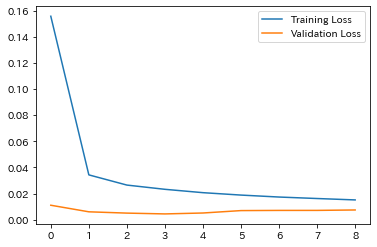

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [12]:
#predict(train data)
train_d_pred = model.predict(train_d)
print(train_d_pred.shape)

#reshape(12000, 164, 1) -> (12000, 164)
train_d_pred = train_d_pred.reshape(12000, 164)

#再構成誤差計算
train_mae_loss = np.mean(np.square(np.abs(train_d_pred - train_d)), axis=1)


#再構成誤差の平均値
train_mae_loss_mean = np.mean(train_mae_loss)

#再構成誤差の標準偏差
train_mae_loss_std = np.std(train_mae_loss)

#閾値設定
#閾値T = μ+3σ (μ:train_dの再構成誤差の平均値、σ:train_d（A（51~60path）200-300kHz）の再構成誤差のの標準偏差)

threshold = train_mae_loss_mean + train_mae_loss_std * 3

375/375 [==============================] - 3s 7ms/step
(12000, 164, 1)


In [13]:
print(train_mae_loss_mean)
print(train_mae_loss_std)
print(threshold)

0.02926096694219461
0.05162089926575669
0.18412366473946468


In [15]:
%%time
# test(A,B,C 1-460pah) predict & reshape & get reconstruction error
test_A_pred = model.predict(test_A)
test_A_pred = test_A_pred.reshape(552000,164)

test_B_pred = model.predict(test_B)
test_B_pred = test_B_pred.reshape(552000,164)

test_C_pred = model.predict(test_C)
test_C_pred = test_C_pred.reshape(470580,164)


test_A_mae_loss = np.mean(np.square(np.abs(test_A_pred - test_A)), axis=1)
test_B_mae_loss = np.mean(np.square(np.abs(test_B_pred - test_B)), axis=1)
test_C_mae_loss = np.mean(np.square(np.abs(test_C_pred - test_C)), axis=1)

14706/14706 [==============================] - 109s 7ms/step
Wall time: 6min 32s


In [16]:
#RE は　Reconstruction Errorの略
test_A_RE = test_A_mae_loss.reshape(-1)
test_B_RE = test_B_mae_loss.reshape(-1)
test_C_RE = test_C_mae_loss.reshape(-1)

print(test_A_RE.shape)
print(test_B_RE.shape)
print(test_C_RE.shape)

(552000,)
(552000,)
(470580,)


In [17]:
# np.save(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_A", test_A_RE)
# np.save(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_B", test_B_RE)
# np.save(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_C", test_C_RE)

np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_A", test_A_RE)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_B", test_B_RE)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_C", test_C_RE)

In [60]:
# test_A_RE = np.load(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_A.npy")
# test_B_RE = np.load(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_B.npy")
# test_C_RE = np.load(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_C.npy")


test_A_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_A.npy")
test_B_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_B.npy")
test_C_RE = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_C.npy")

In [61]:
print(len(test_A_RE)/1200)
print(len(test_B_RE)/1200)
print(len(test_C_RE)/1023)

460.0
460.0
460.0


In [64]:
plt.plot(test_A_RE)
plt.plot(test_B_RE)
plt.plot(test_C_RE)

In [39]:
plt.plot(test_B_RE)
#all_path_num
a_p_n = 460
#all_rotation_num
a_r_n = 1200
a_r_n_2 = 1023
#moving avg path step
m_a_p_s = 10

w_size = a_r_n*m_a_p_s
w_size2 = a_r_n_2*m_a_p_s

x = np.linspace(-1,1,w_size)
x2 = np.linspace(-1,1,w_size2)
v = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)
v2 = np.exp(-x2**2 / 2) / np.sqrt(2 * np.pi)
v = v / np.sum(v)
v2 = v2 / np.sum(v2)
v = np.sort(v)[::-1]
v2 = np.sort(v2)[::-1]

In [40]:
%%time
RE_MA_A = np.convolve(test_A_RE,v, mode='valid')
RE_MA_B = np.convolve(test_B_RE,v, mode='valid')
RE_MA_C = np.convolve(test_C_RE,v2, mode='valid')

Wall time: 1min 13s


In [51]:
%matplotlib qt
plt.plot(RE_MA_A)
plt.plot(RE_MA_B)
plt.plot(RE_MA_C)

In [41]:
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_A_MA", RE_MA_A)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_B_MA", RE_MA_B)
np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_C_MA", RE_MA_C)

In [81]:
tools = ["A", "B", "C"]
intervals = [1200, 1200, 1023]

In [87]:
for tool, interval in zip(tools, intervals):
    RE_MA = np.load(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_{tool}_MA.npy")
    new = RE_MA[:-1]
    print(len(new)/interval)
    new = new.reshape(interval*10, int(len(new)/(interval*10)))
    print(new.shape)
    avg = np.average(new,axis=1)
    print(avg.shape)
    avg = avg.reshape(len(avg),1)
    print(avg.shape)
    avg = np.repeat(avg, 1, axis=1)
    print(avg.shape)
    new_n = np.block([new,avg])
    new_n = new_n.ravel()
    print(len(new_n)/interval)
    
    if tool == "C":
        new_nn = new_n.reshape(int(len(new_n)/interval), interval)
        print(new_nn.shape)
        hokan = 1200-1023
        avg = np.average(new_nn, axis=1)
        avg = avg.reshape(len(avg), 1)
        avg = np.repeat(avg, hokan, axis=1)
        new_nn  = np.block([new_nn, avg])
        print(new_nn.shape)
        new_nn = new_nn.ravel()
        print(len(new_nn)/1200)
        np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_{tool}_MA_EX.npy",new_nn)
    else:
        np.save(rf"Z:\200 Produced_data\MashineLearning\RE\case1_A_{tool}_MA_EX.npy",new_n)


450.0
(12000, 45)
(12000,)
(12000, 1)
(12000, 1)
460.0
450.0
(12000, 45)
(12000,)
(12000, 1)
(12000, 1)
460.0
450.0
(10230, 45)
(10230,)
(10230, 1)
(10230, 1)
460.0
(460, 1023)
(460, 1200)
460.0


In [ ]:
np.save(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_A_MA", RE_MA_A)
np.save(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_B_MA", RE_MA_B)
np.save(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_C_MA", RE_MA_C)

In [94]:
RE_MA_A = np.load(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_A_MA.npy")
RE_MA_B = np.load(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_B_MA.npy")
RE_MA_C = np.load(rf"Z:\200 Produced_data\20230113+0117\RE\A_spindle_51-60_200-300_C_MA.npy")

In [130]:
RE_B = RE_MA_B[:300*1200]
RE_C = RE_MA_C[:300*1200]

In [133]:
cfm_B = np.load(rf"Z:\200 Produced_data\master_paper_data\B\CF\CF_1-460.npy")
cfm_C = np.load(rf"Z:\200 Produced_data\master_paper_data\C\CF\CF_1-460.npy")

cfm_B = cfm_B[:300*1200]
cfm_C = cfm_C[:300*1200]

In [111]:
%matplotlib qt
#all_path_num
a_p_n = 300
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 30


fig = plt.figure()
ax = fig.add_subplot()
ax.set_xticks(np.arange(0, a_p_n*a_r_n + 1, a_r_n*m_a_p_s))
ax.set_xticklabels(np.arange(0,a_p_n + 1,m_a_p_s))
ax.set_xlabel(xlabel='Path Number')
ax.set_ylabel(ylabel='Reconstruction Error')
ax.tick_params(axis = 'x')
ax.tick_params(axis = 'y')
# ax.plot(test_A_RE, label="A")
# ax.plot(test_B_RE, label="B")
# ax.plot(test_C_RE, label="C")
# ax.plot(RE_MA_A, label="A_MA")
# ax.plot(RE_MA_B, label="B_MA")
# ax.plot(RE_MA_C, label="C_MA")


# ax.plot(RE_MA_A[1200*:], label="A_MA")
# ax.plot(RE_MA_C, label="C_MA")



# plt.legend()
plt.grid()

In [128]:
cfm = np.load(rf"Z:\200 Produced_data\master_paper_data\A\CF\CF_1-460.npy")
cfm = cfm[:300*1200]
RE = RE_MA_A[:300*1200]

In [136]:
%matplotlib qt
#all_path_num
a_p_n = 300
#all_rotation_num
a_r_n = 1200
#moving avg path step
m_a_p_s = 30


fig = plt.figure()
ax = fig.add_subplot()
ax.set_xticks(np.arange(0, a_p_n*a_r_n + 1, a_r_n*m_a_p_s))
ax.set_xticklabels(np.arange(0,a_p_n + 1,m_a_p_s))
ax.set_xlabel(xlabel='Path Number')
ax.set_ylabel(ylabel='Cutting Force[N]')
ax.tick_params(axis = 'x')
ax.tick_params(axis = 'y')

ax2 = ax.twinx()
ax2.set_ylabel(ylabel='Reconstruction Error')


ax.plot(cfm_C, label="Cutting Force", linewidth="5")
ax2.plot(RE_C, label="Reconstruction Error", color="magenta")

# ax.plot(RE_MA_B, label="B_MA")
# ax.plot(RE_MA_C, label="C_MA")


# ax.plot(RE_MA_A[1200*:], label="A_MA")
# ax.plot(RE_MA_C, label="C_MA")



# plt.legend()
# plt.grid()

In [ ]:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xticks(np.arange(1, a_p_n*a_r_n, a_r_n*m_a_p_s))
    ax.set_xticklabels(np.arange(0,a_p_n,m_a_p_s))
    ax.set_xlabel(xlabel='Path Number')
    ax.set_ylabel(ylabel='S (AE spectrum area)')
    ax.set_ylabel(ylabel='Cutting Force[N]')
    ax.tick_params(axis = 'x')
    ax.tick_params(axis = 'y')
    ax2 = ax.twinx()
    ax2.set_ylabel(ylabel='S (AE spectrum area)')
    ax.grid()
    ax.plot(cfm, lineWidth="3", label="cutting force")
    ax2.plot(aem, color="magenta")